#### <h1>Machine Learning</h1>

<h2>Lab assignment 5: Feature engineering and classification</h2>

### Team ID:
8

### Student:
Diogo Fonseca, no. 79858

## 0. Import packages

In [1]:
import numpy as np
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/luna/Documents/uni_code/ml/lab4/.venv/lib/python3.13/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 1. Problem description

Wind power is one of the major renewable energy sources. Wind-powered energy
production is done by huge devices commonly called wind turbines. These devices are
usually deployed at high places, where winds are strong, but with limited access,
making maintenance operations expensive. Unexpected faults lead to failures and
unscheduled maintenance which adds a major cost source.
Effective fault diagnosis and prediction can reduce this cost. Components expected to
fail soon can be changed at scheduled maintenance dates.


The drivetrain is a core component of a wind
turbine. It is where the wind mechanical energy
collected by the blades is converted into
electrical energy. It is also under constant stress.
Identifying faults and their causes reduces
maintenance costs, since components about to
fail can be changed at scheduled maintenance
dates.


Some wind turbine drive train faults can be
identified by analysing signals recorded from
sensors such as 3D accelerometers, sound, and
others, assembled on the drive train.


The Wind turbine drive train dataset (WTDT) is
a large database of signals recorded from such
sensors while a wind turbine model operates
under regular or induced drive train fault
conditions.

The dataset contains recordings of the acoustic emission sensor for 20 seconds for each
of the 7 fault classes. Since the signal was sampled at a frequency of 1 MHz, we have
2,000,000 points for each fault class, resulting in a total of 14,000,000 points in the
dataset.


However, the signals are split into samples of 1,000 points, so for each class we have
20,000 samples, totalling 140,000 samples for the 7 Fault classes.
These samples are organised by fault class, with rows 0 to 19,999 of X and Y containing
samples and labels from fault class 0, rows 20,000 to 39,999 from fault class 1, and so
on.

## 2. Data import

In [2]:
dsFile = 'ch6-L1S50F7-w1000-r01-raw.pickle'
with open(dsFile, 'rb') as f:
    data = pickle.load(f)
    X = data['X']
    y = data['Y']

print ("X shape:", X.shape)
print ("Y shape:", y.shape)

X shape: (140000, 1000)
Y shape: (140000, 7)


## 3. Feature extraction

First the data is shuffled, since it's ordered. Then the labels are extracted from the one_hot encoding.

After this we split the data into training and testing datasets, as per the norm.

Then the data is centered on a mean of 0 and standard deviation of 1 (data is centered and scaled).

The most important alteration is then using PCA to get the principal components, so that we can reduce the dimensions of the problem (from 1000) such that we still have 95% of the variance. This decreases computational time, decreases information cluttering (too many dimensions/features with mostly worthless information), which helps the classifiers learn better and faster.

In [3]:
# Seed
seed = 137

# Shuffle data
X_shuffled, y_shuffled = shuffle(X, y, random_state=seed)

# Convert y to labels
y_labels = np.argmax(y_shuffled, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_labels, test_size=0.2, random_state=seed
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=seed)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## 4. Classifier model

Four different classifiers were chosen:
- Random Forest
- Gradient Boosting
- One Over Rest
- Neural Network

From those, a stacking ensemble is done with a logistic regressor to decide what the output should be.

For each of the classifiers, the hyperparameters were chosen experimentally, trying to maximize the f1-score on the test dataset. No grid search nor other hyperparameter optimizers were used, all was carefully tuned manually with what made sense and provided better results. Furthermore no cross validation was made.

## Reasoning
The reasoning behind all this, was that experimentally, none of them had high f1 scores / accuracy (all under ~0.9 f1 score), as such an ensemble made sense to better classify, which experimentally was confirmed to perform much better (0.94 f1 score).

Clustering was also tried, but with a 2d and 3d visualization with PCA, it was confirmed that the data seemed to be all mixed on top of itself, being impossible to cluster at least with either the raw or PCA data.

The ones that made the most sense were (by decreasing order) Random Forests, Neural Networks and Gradient Boosing. One Vs Rest was the naive approach initially done, but due to the high f1-score and accuracy, it was kept.

## Random Forest
The random forest has 200 decision trees and they have no depth limitation. A node must have at least 5 samples to be considered for splitting and each leaf node must have at least 2 samples.

## Gradient Boosting
For gradient boosting, a maximum of 200 iterations was chosen (but it always converges before that) with a learning rate of 0.1.
Regularization was also tuned to 0.1 and early_stopping was employed.

## One Vs Rest
Each estimator is a neural network of topology 256-128 with a relu activation function, adaptative learning rate, regularization of 0.0001, 100 maximum iterations (although they always coverge before that) and early stopping. Each of those is concentrated on classifying one of the classes, of which they are then joint in the One Vs Rest classifier.

## Neural Network
A single neural network with 7 outputs was also trained, with topology 512-256. More layers than this overfits too much, and more neurons (i.e. 1024) already surpass the number of original features (before PCA).

## Stacking ensembler
The ensemble then takes the previous models and uses logistic regression to decide the final class.

In [4]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=seed,
    verbose=True
)

In [5]:
# Gradient Boosting
gb = HistGradientBoostingClassifier(
    max_iter=200,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=20,
    l2_regularization=0.1,
    early_stopping=True,
    scoring='accuracy',
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-7,
    random_state=seed,
    verbose=True
)

In [6]:
# Single neural network model for OneVsRest
ovr_base_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    alpha=0.0001, # regularization
    batch_size=512,
    max_iter=100,
    random_state=seed,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True
)

# One Vs Rest classifier (7 binary classifiers)
ovr = OneVsRestClassifier(
    estimator=ovr_base_model,
    n_jobs=-1,
    verbose=True
)

In [7]:
# Neural Network
nn = MLPClassifier(
    #hidden_layer_sizes=(1024, 512, 256, 128),
    hidden_layer_sizes=(512, 256),
    activation='relu',
    #solver='sgd',
    solver='adam',
    #learning_rate_init=0.01,
    learning_rate='adaptive',
    #learning_rate='constant',
    alpha=0.0001, # regularization
    batch_size=256,
    max_iter=100,
    random_state=seed,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=False
)

In [8]:
# Stacking Ensemble
base_models = [
    ('rf', rf),
    ('gb', gb),
    ('ovr', ovr),
    ('nn', nn)
]

meta_model = LogisticRegression(max_iter=1000, random_state=seed)

stacking_ensemble = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv='prefit',
    n_jobs=-1,
    passthrough=False
)

## 5. Training

In [9]:
# Random Forest
rf.fit(X_train_pca, y_train)
print("Random Forest done training")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min


Random Forest done training


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


In [10]:
# Gradient Boost
gb.fit(X_train_pca, y_train)
print("Gradient Boost done training")

Binning 0.450 GB of training data: 0.543 s
Binning 0.050 GB of validation data: 0.051 s
Fitting gradient boosted rounds:
Fit 1400 trees in 25.712 s, (43275 total leaves)
Time spent computing histograms: 17.343s
Time spent finding best splits:  4.842s
Time spent applying splits:      1.263s
Time spent predicting:           0.182s
Gradient Boost done training


In [11]:
# One Vs Rest
ovr.fit(X_train_pca, y_train)
print("One Vs Rest done training")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


One Vs Rest done training


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   33.1s finished


In [12]:
# Neural Network
nn.fit(X_train_pca, y_train)
print("Neural Network done training")

Neural Network done training


In [13]:
# Ensemble
stacking_ensemble.fit(X_train_pca, y_train)
print("Ensemble done training")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


Ensemble done training


## 6. score

In [14]:
# Random Forest

y_pred = rf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
acc = rf.score(X_test_pca, y_test)

print()
print("Random Forest score")
print(report)
print(f"Accuracy: {acc:.2f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



Random Forest score
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3991
           1       0.94      0.91      0.92      3932
           2       0.70      0.87      0.77      4054
           3       0.69      0.49      0.57      3964
           4       0.88      0.80      0.84      4074
           5       0.84      0.91      0.88      3939
           6       0.93      0.95      0.94      4046

    accuracy                           0.82     28000
   macro avg       0.82      0.82      0.81     28000
weighted avg       0.82      0.82      0.81     28000

Accuracy: 0.82


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


In [15]:
# Gradient Boost

y_pred = gb.predict(X_test_pca)
report = classification_report(y_test, y_pred)
acc = gb.score(X_test_pca, y_test)
print()
print("Gradient Boost score")
print(report)
print(f"Accuracy: {acc:.2f}")


Gradient Boost score
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      3991
           1       0.93      0.96      0.94      3932
           2       0.83      0.84      0.83      4054
           3       0.78      0.72      0.75      3964
           4       0.91      0.83      0.87      4074
           5       0.88      0.92      0.90      3939
           6       0.94      0.98      0.96      4046

    accuracy                           0.87     28000
   macro avg       0.87      0.87      0.87     28000
weighted avg       0.87      0.87      0.87     28000

Accuracy: 0.87


In [16]:
# One Vs Rest

y_pred = ovr.predict(X_test_pca)
report = classification_report(y_test, y_pred)
acc = ovr.score(X_test_pca, y_test)
print()
print("One Vs Rest score")
print(report)
print(f"Accuracy: {acc:.2f}")


One Vs Rest score
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3991
           1       0.94      0.97      0.95      3932
           2       0.93      0.92      0.92      4054
           3       0.88      0.87      0.88      3964
           4       0.88      0.87      0.88      4074
           5       0.90      0.92      0.91      3939
           6       0.95      0.96      0.96      4046

    accuracy                           0.91     28000
   macro avg       0.91      0.91      0.91     28000
weighted avg       0.91      0.91      0.91     28000

Accuracy: 0.91


In [17]:
# Neural Network

y_pred = nn.predict(X_test_pca)
report = classification_report(y_test, y_pred)
acc = nn.score(X_test_pca, y_test)
print()
print("Neural Network score")
print(report)
print(f"Accuracy: {acc:.2f}")


Neural Network score
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3991
           1       0.95      0.95      0.95      3932
           2       0.89      0.91      0.90      4054
           3       0.86      0.83      0.84      3964
           4       0.89      0.87      0.88      4074
           5       0.89      0.91      0.90      3939
           6       0.96      0.96      0.96      4046

    accuracy                           0.90     28000
   macro avg       0.90      0.90      0.90     28000
weighted avg       0.90      0.90      0.90     28000

Accuracy: 0.90


In [18]:
# Stacking Ensemble

y_pred = stacking_ensemble.predict(X_test_pca)
report = classification_report(y_test, y_pred)
acc = stacking_ensemble.score(X_test_pca, y_test)
print()
print("Stacking Ensemble score")
print(report)
print(f"Accuracy: {acc:.2f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished



Stacking Ensemble score
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3991
           1       0.97      0.98      0.97      3932
           2       0.93      0.95      0.94      4054
           3       0.93      0.90      0.91      3964
           4       0.92      0.89      0.90      4074
           5       0.91      0.95      0.93      3939
           6       0.97      0.98      0.98      4046

    accuracy                           0.94     28000
   macro avg       0.94      0.94      0.94     28000
weighted avg       0.94      0.94      0.94     28000

Accuracy: 0.94


## 7. Data balancing and errors

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


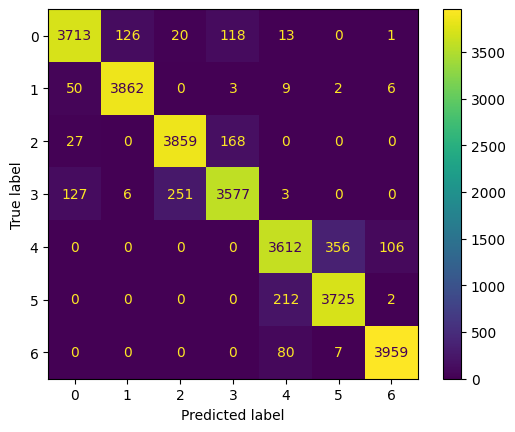

In [19]:
y_pred = stacking_ensemble.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The dataset was balanced, having an equal number of examples for each class.

From the confusion matrix we can clearly tell that the classifier is confusing class 4 with class 5 (and vice versa) and class 2 with 3 mainly, but it also has some confusion between class 3 and 0, 4 and 6 and 0 and 1. By decreasing order of how much it confuses these pairs:
- (4, 5)
- (2, 3)
- (0, 3)
- (4, 6)
- (0, 1)

Other than these, which outside of the top 2, confusions between the others were rare, mainly predicting accurately the right class. This can be further confirmed by checking the f1 score, which was 0.94.